# Coursea IBM Data Science Capstone Project

This will be a notebook for the Coursea IBM Data Science Capston Project.

### first import the needed packages

In [5]:
import numpy as np
import pandas as pd

import requests
import json
import lxml.html as lh
import re

import geocoder 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#pdf scraping
import camelot
import tabula
import os

print('all packages loaded!')

all packages loaded!


### Lebenräulichestadtgliederung:
https://www.stadtentwicklung.berlin.de/planen/basisdaten_stadtentwicklung/lor/download/LOR_2021_Registerseite.pdf 
<br>
https://www.stadtentwicklung.berlin.de/planen/basisdaten_stadtentwicklung/lor/de/download.shtml    

### let's read docx file into a pandas frame

In [15]:
from docx.api import Document

document = Document('LOR-Schluesselsystematik_2021.docx')
table = document.tables[0]


data = []

keys = None
for i, row in enumerate(table.rows):
    text = (cell.text for cell in row.cells)

    if i == 0:
        keys = tuple(text)
        continue
    row_data = dict(zip(keys, text))
    data.append(row_data)

In [43]:
df = pd.DataFrame(data)
df[:10]

,PGR \nID,PGR Name,BZR ID,BZR Name,PLR ID,PLR Name,EW 31.12.19
0,01 Mitte,01 Mitte,01 Mitte,01 Mitte,01 Mitte,01 Mitte,01 Mitte
1,0110,Zentrum,011001,Tiergarten Süd,01100101,Stülerstraße,3.445
2,0110,Zentrum,011001,Tiergarten Süd,01100102,Großer Tiergarten,1.755
3,0110,Zentrum,011001,Tiergarten Süd,01100103,Lützowstraße,5.159
4,0110,Zentrum,011001,Tiergarten Süd,01100104,Körnerstraße,4.626
5,0110,Zentrum,011001,Tiergarten Süd - gesamt,Tiergarten Süd - gesamt,Tiergarten Süd - gesamt,14.985
6,0110,Zentrum,011002,Regierungsviertel,01100205,Wilhelmstraße,2.456
7,0110,Zentrum,011002,Regierungsviertel,01100206,Unter den Linden,1.825
8,0110,Zentrum,011002,Regierungsviertel,01100207,Leipziger Straße,8.461
9,0110,Zentrum,011002,Regierungsviertel - gesamt,Regierungsviertel - gesamt,Regierungsviertel - gesamt,12.742


#### lets remove summary rows

In [163]:
df = pd.DataFrame(data)

#df_PLR = df.drop([0]).reset_index() # shit da sind noch mehr drin
df_PLR = df.drop(['PGR \nID'], axis=1)
df_PLR = df_PLR.drop(['BZR ID'], axis=1)

i=0

for item in df_PLR['BZR Name']:
    if item.find('gesamt') != -1:
        df_PLR=df_PLR.drop([i])
    i+=1    
i=1    
#df_PLR.reset_index()
index=[]
for item in df_PLR['PLR ID']:
    if len(item) > 8:
        print(i,item)
        index.append(i)
        print(index)
        #df_PLR_n=df_PLR.drop([i])
    i+=1
df_PLR=df_PLR.drop(df_PLR.index[index])           
df_PLR = df_PLR.drop([0]).reset_index()            
    #i+=1
#df_PLR=df_PLR.drop([49])
#df_PLR=df_PLR.drop([86])
#df_PLR=df_PLR.drop([147])
#print(df_PLR[201])
df_PLR.head()

51 02 Friedrichshain-Kreuzberg
[51]
88 03 Pankow
[51, 88]
149 04 Charlottenburg-Wilmersdorf
[51, 88, 149]
203 05 Spandau
[51, 88, 149, 203]
249 06 Steglitz-Zehlendorf
[51, 88, 149, 203, 249]
294 07 Tempelhof-Schöneberg
[51, 88, 149, 203, 249, 294]
343 08 Neukölln
[51, 88, 149, 203, 249, 294, 343]
390 09 Treptow-Köpenick
[51, 88, 149, 203, 249, 294, 343, 390]
434 10 Marzahn-Hellersdorf
[51, 88, 149, 203, 249, 294, 343, 390, 434]
476 11 Lichtenberg
[51, 88, 149, 203, 249, 294, 343, 390, 434, 476]
518 12 Reinickendorf
[51, 88, 149, 203, 249, 294, 343, 390, 434, 476, 518]


,index,PGR Name,BZR Name,PLR ID,PLR Name,EW 31.12.19
0,1,Zentrum,Tiergarten Süd,01100101,Stülerstraße,3.445
1,2,Zentrum,Tiergarten Süd,01100102,Großer Tiergarten,1.755
2,3,Zentrum,Tiergarten Süd,01100103,Lützowstraße,5.159
3,4,Zentrum,Tiergarten Süd,01100104,Körnerstraße,4.626
4,6,Zentrum,Regierungsviertel,01100205,Wilhelmstraße,2.456


### some small shaping of the Dataframe

In [164]:
#cols = list(df_PLR.columns.values)
#print(cols)
df_PLR = df_PLR[['PLR ID','PGR Name', 'BZR Name', 'PLR Name', 'EW 31.12.19']]
df_PLR.head()

,PLR ID,PGR Name,BZR Name,PLR Name,EW 31.12.19
0,01100101,Zentrum,Tiergarten Süd,Stülerstraße,3.445
1,01100102,Zentrum,Tiergarten Süd,Großer Tiergarten,1.755
2,01100103,Zentrum,Tiergarten Süd,Lützowstraße,5.159
3,01100104,Zentrum,Tiergarten Süd,Körnerstraße,4.626
4,01100205,Zentrum,Regierungsviertel,Wilhelmstraße,2.456


#### now find the coordinates of each borogh

In [167]:
# initialize your variable to None
latitude_PLR =[]
longitude_PLR=[]

for row in zip(df_PLR['PGR Name'],df_PLR['BZR Name'],df_PLR['PLR Name']):
    Lokation = row[2]+' '+row[1]+' '+'Berlin'
    print(Lokation)
    lat_lng_coords = None
    i=0
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Berlin, Berlin'.format(Lokation)) #arcgis worked!!
        print(i,g)
        lat_lng_coords = g.latlng
        i+=1

    latitude_PLR.append(lat_lng_coords[0])
    longitude_PLR.append(lat_lng_coords[1])
print('done')    

Stülerstraße Tiergarten Süd Berlin
0 <[OK] Arcgis - Geocode [Stülerstraße, 10787, Berlin, Tiergarten, Berlin]>
Großer Tiergarten Tiergarten Süd Berlin
0 <[OK] Arcgis - Geocode [Tiergarten]>
Lützowstraße Tiergarten Süd Berlin
0 <[OK] Arcgis - Geocode [Lützowstraße, 10785, Berlin, Tiergarten, Berlin]>
Körnerstraße Tiergarten Süd Berlin
0 <[OK] Arcgis - Geocode [Körnerstraße, 10785, Berlin, Tiergarten, Berlin]>
Wilhelmstraße Regierungsviertel Berlin
0 <[OK] Arcgis - Geocode [Wilhelmstraße, 10117, Berlin, Mitte, Berlin]>
Unter den Linden Regierungsviertel Berlin
0 <[OK] Arcgis - Geocode [Unter den Linden, 10117, Berlin, Mitte, Berlin]>
Leipziger Straße Regierungsviertel Berlin
0 <[OK] Arcgis - Geocode [Leipziger Straße, 10117, Berlin, Mitte, Berlin]>
Charitéviertel Alexanderplatz Berlin
0 <[OK] Arcgis - Geocode [Alexanderplatz, 10178, Berlin, Mitte, Berlin]>
Oranienburger Straße Alexanderplatz Berlin
0 <[OK] Arcgis - Geocode [Oranienburger Straße, 10115, Berlin, Mitte, Berlin]>
Alexanderpl

#### check the size

In [168]:
print(len(latitude_PLR),len(longitude_PLR))

542 542


#### append the coordinates to the datafram borogh

In [169]:
df_PLR['Latitude'] = latitude_PLR
df_PLR['Longitude'] = longitude_PLR


#  The nighborhood table with coordinates

In [170]:
df_PLR.head()

,PLR ID,PGR Name,BZR Name,PLR Name,EW 31.12.19,Latitude,Longitude
0,01100101,Zentrum,Tiergarten Süd,Stülerstraße,3.445,52.507528,13.348435
1,01100102,Zentrum,Tiergarten Süd,Großer Tiergarten,1.755,52.517500,13.364860
2,01100103,Zentrum,Tiergarten Süd,Lützowstraße,5.159,52.503663,13.362630
3,01100104,Zentrum,Tiergarten Süd,Körnerstraße,4.626,52.501515,13.367190
4,01100205,Zentrum,Regierungsviertel,Wilhelmstraße,2.456,52.513446,13.382372


## ok lets have a look on the spatial distribution


In [171]:
g = geocoder.arcgis('Berlin, Berlin')
t_latitude=lat_lng_coords[0]
t_longitude=lat_lng_coords[1]

# create map of Toronto using latitude and longitude values
map_Berlin = folium.Map(location=[t_latitude, t_longitude], zoom_start=10)

# add markers to map
for lat, lng, PGR, BZR, PLR in zip(df_PLR['Latitude'], df_PLR['Longitude'], df_PLR['PGR Name'], df_PLR['BZR Name'], df_PLR['PLR Name']):
    label = '{}, {}'.format(PLR, BZR, PGR)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Berlin)  
    
map_Berlin

# now lets get the venue data for each neighborhood
<br>
first the credentials

In [172]:
CLIENT_ID = 'HIBD3BSH1HC3WCWEV4TOPHCDRXYSWGVAJFSUJ22P3UK50BEZ' # your Foursquare ID
CLIENT_SECRET = 'WS4RI3033W3CM5LCWXIDA5A1KTM2AOT4GPM3XVUTWLPJX2P2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HIBD3BSH1HC3WCWEV4TOPHCDRXYSWGVAJFSUJ22P3UK50BEZ
CLIENT_SECRET:WS4RI3033W3CM5LCWXIDA5A1KTM2AOT4GPM3XVUTWLPJX2P2


#### now we define a function to get every venue in the vecinity of our neighberhoods from Foursquare

In [173]:
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### lets get the data

In [174]:
# get info
Berlin_venues = getNearbyVenues(names=df_PLR['PLR Name'],
                                   latitudes=df_PLR['Latitude'],
                                   longitudes=df_PLR['Longitude']
                                  )
print('done')

Stülerstraße
Großer Tiergarten
Lützowstraße
Körnerstraße
Wilhelmstraße
Unter den Linden
Leipziger Straße
Charitéviertel
Oranienburger Straße
Alexanderplatzviertel
Karl-Marx-Allee
Heine-Viertel West
Heine-Viertel Ost
Nordbahnhof
Invalidenstraße
Arkonaplatz
Huttenkiez
Beusselkiez
Emdener Straße
Bremer Straße
Zwinglistraße
Elberfelder Straße
Stephankiez
Heidestraße
Lübecker Straße
Thomasiusstraße
Zillesiedlung
Lüneburger Straße
Hansaviertel
Drontheimer Straße
Koloniestraße
Soldiner Straße
Gesundbrunnen
Brunnenstraße
Humboldthain Süd
Humboldthain Nordwest
Afrikanische Straße
Kameruner Straße
Glasgower Straße
Schillerpark
Londoner Straße
Westliche Müllerstraße
Antonstraße
Uferstraße
Schwedenstraße
Nordufer
Sparrplatz
Leopoldplatz
Schulstraße
02 Friedrichshain-Kreuzberg
Mehringplatz
Am Berlin Museum
Moritzplatz 
Prinzenstraße
Wassertorplatz
Gleisdreieck
Rathaus Yorckstraße
Viktoriapark
Urbanstraße
Chamissokiez
Graefekiez Süd
Graefekiez Nord
Oranienplatz
Lausitzer Platz
Köpenicker Straße 
Rei

### Let's check the size of the resulting dataframe

In [175]:
print(Berlin_venues.shape)
Berlin_venues.head()

(15709, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Stülerstraße,52.507528,13.348435,Das Stue,52.509876,13.346076,Hotel
1,Stülerstraße,52.507528,13.348435,InterContinental Berlin,52.507212,13.345330,Hotel
2,Stülerstraße,52.507528,13.348435,Stue Bar,52.509885,13.346119,Hotel Bar
3,Stülerstraße,52.507528,13.348435,Pullman Berlin Schweizerhof,52.506029,13.343986,Hotel
4,Stülerstraße,52.507528,13.348435,InterContinental Club Lounge,52.506811,13.345588,Lounge


In [176]:
Berlin_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
02 Friedrichshain-Kreuzberg,100,100,100,100,100,100
03 Pankow,44,44,44,44,44,44
04 Charlottenburg-Wilmersdorf,35,35,35,35,35,35
05 Spandau,55,55,55,55,55,55
06 Steglitz-Zehlendorf,31,31,31,31,31,31
...,...,...,...,...,...,...
Zingster Straße West,5,5,5,5,5,5
Zitadellenweg,17,17,17,17,17,17
Zittauer Straße,3,3,3,3,3,3


### Let's find out how many unique categories can be curated from all the returned venues

In [177]:
print('There are {} uniques categories.'.format(len(Berlin_venues['Venue Category'].unique())))

There are 402 uniques categories.


## Analyze Each Neighborhood

In [179]:
# one hot encoding
Berlin_onehot = pd.get_dummies(Berlin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Berlin_onehot['Neighborhood'] = Berlin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Berlin_onehot.columns[-1]] + list(Berlin_onehot.columns[:-1])
Berlin = Berlin_onehot[fixed_columns]

Berlin_onehot.head()

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,...,Weight Loss Center,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [180]:
Berlin_onehot.shape

(15709, 402)

### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [181]:
Berlin_grouped = Berlin_onehot.groupby('Neighborhood').mean().reset_index()
Berlin_grouped

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,...,Weight Loss Center,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,02 Friedrichshain-Kreuzberg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,0.02,0.000000,0.0,0.010000,0.0,0.0
1,03 Pankow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.0
2,04 Charlottenburg-Wilmersdorf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.0
3,05 Spandau,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.0
4,06 Steglitz-Zehlendorf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.032258,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,Zingster Straße West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.0
537,Zitadellenweg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.0
538,Zittauer Straße,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.0
539,Zossener Straße,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.142857,0.0,0.000000,0.0,0.0


#### Let's confirm the new size

In [182]:
Berlin_grouped.shape

(541, 402)

## Let's print each neighborhood along with the top 5 most common venues

In [183]:
num_top_venues = 5

for hood in Berlin_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Berlin_grouped[Berlin_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----02 Friedrichshain-Kreuzberg----
                venue  freq
0                Café  0.12
1                 Bar  0.06
2  Falafel Restaurant  0.05
3         Coffee Shop  0.05
4     Thai Restaurant  0.04


----03 Pankow----
              venue  freq
0              Café  0.18
1            Bakery  0.07
2       Supermarket  0.05
3    Ice Cream Shop  0.05
4  Sushi Restaurant  0.05


----04 Charlottenburg-Wilmersdorf----
                venue  freq
0         Supermarket  0.09
1  Italian Restaurant  0.09
2                Park  0.06
3    Sushi Restaurant  0.06
4                Pool  0.06


----05 Spandau----
               venue  freq
0          Drugstore  0.05
1             Bakery  0.05
2         Restaurant  0.04
3  Trattoria/Osteria  0.04
4     Ice Cream Shop  0.04


----06 Steglitz-Zehlendorf----
                venue  freq
0                Café  0.16
1  Italian Restaurant  0.10
2                Bank  0.06
3         Supermarket  0.06
4    Doner Restaurant  0.06


----07 Tempelhof-Schöneber

## Let's put that into a _pandas_ dataframe

First, let's write a function to sort the venues in descending order.

In [223]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [224]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Berlin_grouped['Neighborhood']

for ind in np.arange(Berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Berlin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,02 Friedrichshain-Kreuzberg,Café,Bar,Falafel Restaurant,Coffee Shop,Thai Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Bagel Shop,Bookstore
1,03 Pankow,Café,Bakery,Ice Cream Shop,Sushi Restaurant,Drugstore,Park,Supermarket,Tram Station,Clothing Store,Eastern European Restaurant
2,04 Charlottenburg-Wilmersdorf,Italian Restaurant,Supermarket,Pool,Park,Café,Sushi Restaurant,Bakery,Trattoria/Osteria,Bank,Drugstore
3,05 Spandau,Bakery,Drugstore,Pub,Trattoria/Osteria,Bus Stop,Mobile Phone Shop,Clothing Store,Restaurant,Café,Ice Cream Shop
4,06 Steglitz-Zehlendorf,Café,Italian Restaurant,Doner Restaurant,Bank,Supermarket,Drugstore,Fast Food Restaurant,Big Box Store,Gourmet Shop,Organic Grocery


In [225]:
Berlin_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,...,Weight Loss Center,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,02 Friedrichshain-Kreuzberg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,0.02,0.0,0.0,0.010000,0.0,0.0
1,03 Pankow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0
2,04 Charlottenburg-Wilmersdorf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0
3,05 Spandau,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0
4,06 Steglitz-Zehlendorf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.032258,0.0,0.0


# Cluster Neighborhoods

Run _k_-means to cluster the neighborhood into 5 clusters.

[33 29 39 37 29 39  1 29 12  3 44 23 38 37 38  3 21 21 19 37 39 19 18 17
  6 37  3 40  3 24 33 37 29 33 33 23 35 17 12 33 41 23  3 24  7 33 33 33
 19 40 10 37 39 37 33  3 37 39 39 33 39 33 12 33 19 33 23 19 19 37 33 14
 14 47 24 39 47 28 39 10 39  4 33 37 24 39 39 24 37 33 29 39 22 22 22 17
 40 24 23 33  6 40 37 33 19 21  3 33 33 29 10  3 25 19 39 15 29 33 37  8
 30 30 25 12 38 24 23 37 24 33  7 33 19 37 29  2  2 33 39 47 39 33 24 39
 24 24 29  1 33  3 33 19 24  3 24 39 39  7 33 39 39 24 39  1 39 23 17 23
 37  5  7 37 33  8  1 37 21 10 39 38 37 21 21 23 19 39 45 47 47 19 19 39
 37 33 47 17 24 21 24 37  5  0 37  2 33 12  9 38 39 18 18  3  3 13  2  2
 47 33 42 42 39  1  3 39 37 24  0 37 33  2  7  7 33 33 33 24 37 32 33 20
 19 23 33 37 35  7 19 19 19 33 49 29  6  3 37 33 33  3 39 39 39  0 17 17
 17 29 19 19 26 29 24 29 23 33  7  7 33 33 36  8 23 15 24 17 24 23 47 21
 15 37 31 37  1 37 47 40  7 31 36 36 33  0 37 39 33 31 10 29 39  7 37  3
 48 33 37 37 24 35  7  2 29 24 24 12 33 47 40 12 17

<BarContainer object of 50 artists>

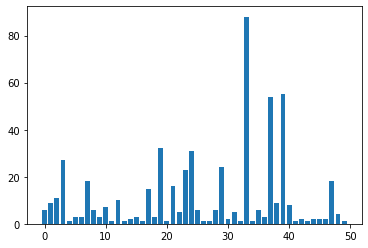

In [226]:
# set number of clusters
kclusters = 50

Berlin_grouped_clustering = Berlin_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Berlin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_)

#and occurence
unique, counts = np.unique(kmeans.labels_, return_counts=True)

#check the occurence for each cluster
A=np.asarray((counts, unique)).T
X=A[:,1]
Y=A[:,0]
print(A)


plt.bar(X,Y,align='center')
 

             

the main cluster aer nr: 16, 1,  14 and 12

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [227]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#print(neighborhoods_venues_sorted)

#df is the data frame contaning the information on every single neighberhood
Berlin_merged = df_PLR

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Berlin_merged = Berlin_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='PLR Name')
Berlin_merged = Berlin_merged.dropna()
Berlin_merged['Cluster Labels']=Berlin_merged['Cluster Labels'].astype('int')
Berlin_merged.head() # check the last columns

,PLR ID,PGR Name,BZR Name,PLR Name,EW 31.12.19,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,01100101,Zentrum,Tiergarten Süd,Stülerstraße,3.445,52.507528,13.348435,37,Hotel,Zoo Exhibit,Italian Restaurant,Café,Lounge,Hotel Bar,German Restaurant,Bar,Nightclub,Breakfast Spot
1,01100102,Zentrum,Tiergarten Süd,Großer Tiergarten,1.755,52.517500,13.364860,37,Seafood Restaurant,Monument / Landmark,Beach,Beer Garden,Performing Arts Venue,French Restaurant,Track,Trail,Outdoor Sculpture,Bistro
2,01100103,Zentrum,Tiergarten Süd,Lützowstraße,5.159,52.503663,13.362630,37,Hotel,Art Gallery,Bar,Lounge,Restaurant,Bus Stop,German Restaurant,Roof Deck,General Entertainment,Gym / Fitness Center
3,01100104,Zentrum,Tiergarten Süd,Körnerstraße,4.626,52.501515,13.367190,37,Hotel,Café,Art Gallery,Bakery,Restaurant,Bar,Park,Coffee Shop,Vietnamese Restaurant,Gastropub
4,01100205,Zentrum,Regierungsviertel,Wilhelmstraße,2.456,52.513446,13.382372,37,Clothing Store,Hotel,Plaza,Gourmet Shop,Restaurant,Hotel Bar,Department Store,German Restaurant,Supermarket,Coffee Shop


Finally, let's visualize the resulting clusters

In [228]:
# create map
map_clusters = folium.Map(location=[t_latitude, t_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, PLR in zip(Berlin_merged['Latitude'], Berlin_merged['Longitude'], Berlin_merged['PLR Name'], Berlin_merged['Cluster Labels'], Berlin_merged['BZR Name']):
    label = folium.Popup(str(poi) + ', ' +str(PLR) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


# evaluate some cluster

### cluster 16 has the highest amount of menbers:

In [229]:
Berlin_merged.loc[Berlin_merged['Cluster Labels'] == 33, Berlin_merged.columns[[1] + list(range(5, Berlin_merged.shape[1]))]].describe(include = 'object')

,PGR Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,89,89,89,89,89,89,89,89,89,89,89
unique,20,12,23,31,33,33,30,39,35,42,50
top,Friedrichshain Ost,Café,Café,Bar,Italian Restaurant,Bakery,Bar,Vietnamese Restaurant,Coffee Shop,Thai Restaurant,Ice Cream Shop
freq,10,52,24,12,12,10,11,13,13,10,11


#### most common for this cluster seems to be coffee shops and restaurant
maybe buissnes are?

### cluster 2 has the second highest amount of members:

In [230]:
Berlin_merged.loc[Berlin_merged['Cluster Labels'] == 37, Berlin_merged.columns[[1] + list(range(5, Berlin_merged.shape[1]))]].describe(include = 'object')

,PGR Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,54,54,54,54,54,54,54,54,54,54,54
unique,22,24,24,28,32,32,34,35,34,42,40
top,Wilmersdorf Zentrum,Hotel,Bakery,Café,Café,Coffee Shop,German Restaurant,Burger Joint,Plaza,Fast Food Restaurant,Turkish Restaurant
freq,15,24,7,10,7,9,9,6,7,8,6


#### most common for this cluster seems to be Grocery Stores, Pharmacy, Liquor Store
maybe living area are?

### cluster 14 has the third highest amount of members:

In [221]:
Berlin_merged.loc[Berlin_merged['Cluster Labels'] == 2, Berlin_merged.columns[[1] + list(range(5, Berlin_merged.shape[1]))]].describe(include = 'object')

,PGR Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,40,40,40,40,40,40,40,40,40,40,40
unique,17,1,22,23,24,18,14,14,10,9,10
top,Hellersdorf,Supermarket,Bus Stop,Metro Station,Falafel Restaurant,Farm,Farmers Market,Farm,Farmers Market,Fast Food Restaurant,Fish Market
freq,7,40,8,5,4,9,9,10,11,10,10


### cluster 12 has the forth highest amount of members:


In [222]:
Berlin_merged.loc[Berlin_merged['Cluster Labels'] == 3, Berlin_merged.columns[[1] + list(range(5, Berlin_merged.shape[1]))]].describe(include = 'object')

,PGR Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,323,323,323,323,323,323,323,323,323,323,323
unique,63,65,70,78,85,84,89,97,96,105,102
top,Wilmersdorf Zentrum,Café,Café,Bakery,Café,Coffee Shop,Café,Farm,Coffee Shop,Fast Food Restaurant,Ice Cream Shop
freq,18,77,43,26,24,30,16,14,23,21,14
